In [2]:
import xarray as xr
import numpy as np
import os
import sitt
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmclimate
import pandas as pd
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['legend.fontsize'] = 16

In [2]:
%run plot.py
%run structfunc.py

In [14]:
gsw.rho_alpha_beta?

Signature: gsw.rho_alpha_beta(SA, CT, p)
Docstring:
Calculates in-situ density, the appropriate thermal expansion
coefficient and the appropriate saline contraction coefficient of seawater
from Absolute Salinity and Conservative Temperature.  This function uses
the computationally-efficient 48-term expression for density in terms of
SA, CT and p (McDougall et al., 2011).

The potential density (pot_rho) with respect to reference pressure p_ref is
obtained by calling this function with the pressure argument being p_ref as
in pot_rho, _, _] = rho_alpha_beta(SA, CT, p_ref).

Parameters
----------
SA : array_like
     Absolute Salinity  [g/kg]
CT : array_like
     Conservative Temperature [:math:`^\circ` C (ITS-90)]
p : array_like
    sea pressure [dbar]

Returns
-------
rho : array_like
      in-situ density [kg/m**3]
alpha : array_like
        thermal expansion coefficient [K :math:`-1`]
        with respect to Conservative Temperature
beta : array_like
       saline contraction coeffici

# Useful functions

In [3]:
def open_ADCP_segments(input_path):
    import glob
    list_of_path = sorted(glob.glob(input_path + "*/*_segment_*.nc"))
    return [xr.open_dataset(path, autoclose=True) for path in list_of_path]

In [4]:
def get_valid_D2(D2, slopes, depth_slice, min_slope=0.2):
    valid_segments = slopes.sel(depth=depth_slice).where(slopes > min_slope).dropna('segment')['segment'].data
    return D2.sel(depth=depth_slice, segment=valid_segments)

In [5]:
def compute_slope(D2):
    import dask.array as da
    from xscale.signal.fitting import linreg
    from xscale.spectral.tools import fit_power_law, plot_power_law 
    slopes = np.nan * np.ones((D2.sizes['depth'], D2.sizes['segment']))
    for z in range(D2.sizes['depth']):
        for s in range(D2.sizes['segment']):
            D2_seg = D2.isel(segment=s, depth=z).dropna('r').chunk()
            if D2_seg.sizes['r'] > 0:
                #slope = linreg(D2_log_seg, dim='r', coord=da.log(D2_log_seg['r'])).sel(degree=1)
                power, scale_factor = fit_power_law(D2_seg['r'], D2_seg['D2u'] + D2_seg['D2v'])
                slopes[z, s] = power
    return xr.DataArray(slopes, dims=('depth', 'segment'), 
                        coords={'depth': D2['depth'], 'segment': D2['segment'], 'time': D2['time']})

# Build the computation of the structure functions on one segment
This section is dedicated to define parameters to select only significative data

In [6]:
input_path = "/data/OBS/ADCP/vanuatu_segments/"
segments = open_ADCP_segments(input_path)
seg = segments[25].set_coords(('lon', 'lat', 'heading', 'uship', 'vship'))
# Get only data with pflag equals 0
seg = seg.where(seg['pflag'] == 0)
# Rotate velocity vectors to get longitudinal and tranverse velocities
#seg = rotate_velocity(seg)
seg

IndexError: list index out of range

NameError: name 'seg' is not defined

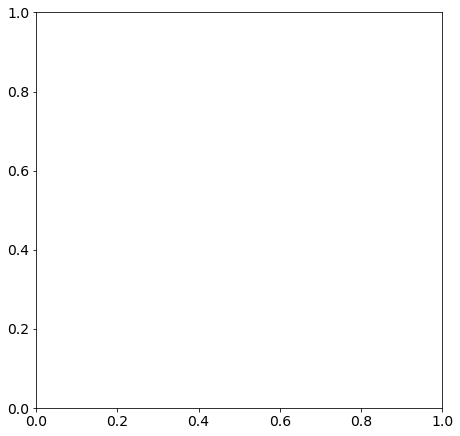

In [7]:
matplotlib.rcParams['figure.figsize'] = (16, 16)
ax_error = plt.subplot(221)
np.log(np.abs(seg['e'])).plot(vmin=-7, vmax=-2)
ax_error.invert_yaxis()
ax_error.set_title("Instrumental error $(m.s^{-1})$")
ax_pg = plt.subplot(222)
seg['pg'].plot(vmin=0, vmax=100)
ax_pg.invert_yaxis()
ax_u  = plt.subplot(223)
seg['u'].plot(vmin=-0.5, vmax=0.5, cmap='RdBu')
ax_u.set_title("Zonal velocity $(m.s^{-1})$")
ax_u.invert_yaxis()
ax_v = plt.subplot(224)
seg['v'].plot(vmin=-0.5, vmax=0.5, cmap='RdBu')
ax_v.set_title("Meridional velocity $(m.s^{-1})$")
ax_v.invert_yaxis()
plt.tight_layout()

## 2 - Compute structures functions

In [8]:
import seaobs.turbulence as turb
nobs = seg.sizes['time']
maxlag = nobs
#D2 = turb.strfunc(seg, dim='time', max_lag=maxlag, vars=['u', 'v'], error_vars='e') 
D2 = velocity_structure_function(seg, dim='time', max_lag=maxlag, error='e')
D2_valid = D2.where((D2['D2l'] > D2['D2_err']) & (D2['D2t'] > D2['D2_err']))
D2_valid

NameError: name 'seg' is not defined

In [9]:
%pdb off

Automatic pdb calling has been turned OFF


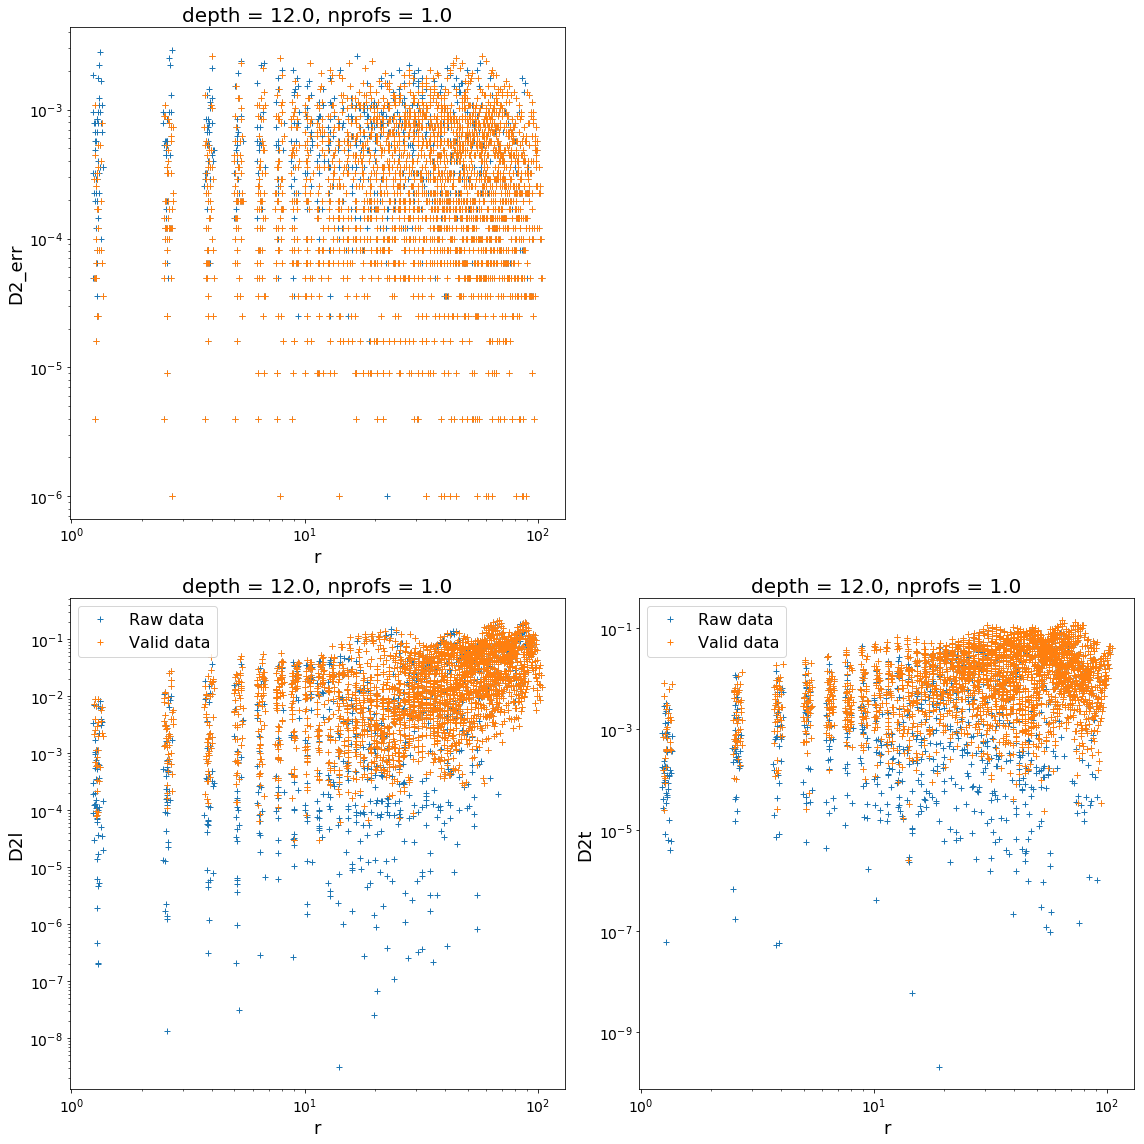

In [10]:
D2_surf = D2.isel(depth=0)
D2_valid_surf = D2_valid.isel(depth=0)
ax_d2error = plt.subplot(221)
D2_surf['D2_err'].plot(ls='', marker='+')
D2_valid_surf['D2_err'].plot(ls='', marker='+')
plt.xscale('log')
plt.yscale('log')
ax_d2u = plt.subplot(223)
D2_surf['D2l'].plot(ls='', marker='+', label="Raw data")
D2_valid_surf['D2l'].plot(ls='', marker='+', label="Valid data")
plt.xscale('log')
plt.yscale('log')
plt.legend()
ax_d2v = plt.subplot(224)
D2_surf['D2t'].plot(ls='', marker='+', label="Raw data")
D2_valid_surf['D2t'].plot(ls='', marker='+', label="Valid data")
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.legend()

## 3 - Resample structure functions over depth levels

In [11]:
# Resample data
depth_bins = range(0, 500, 25)
depth_labels = depth_bins[1:] - np.diff(depth_bins) / 2
D2_resample = D2_valid.groupby_bins('depth', depth_bins, labels=depth_labels).mean('depth').rename({'depth_bins': 'depth'})

In [12]:
D2_surface = D2_resample.sel(depth=slice(0, 100)).mean('depth')

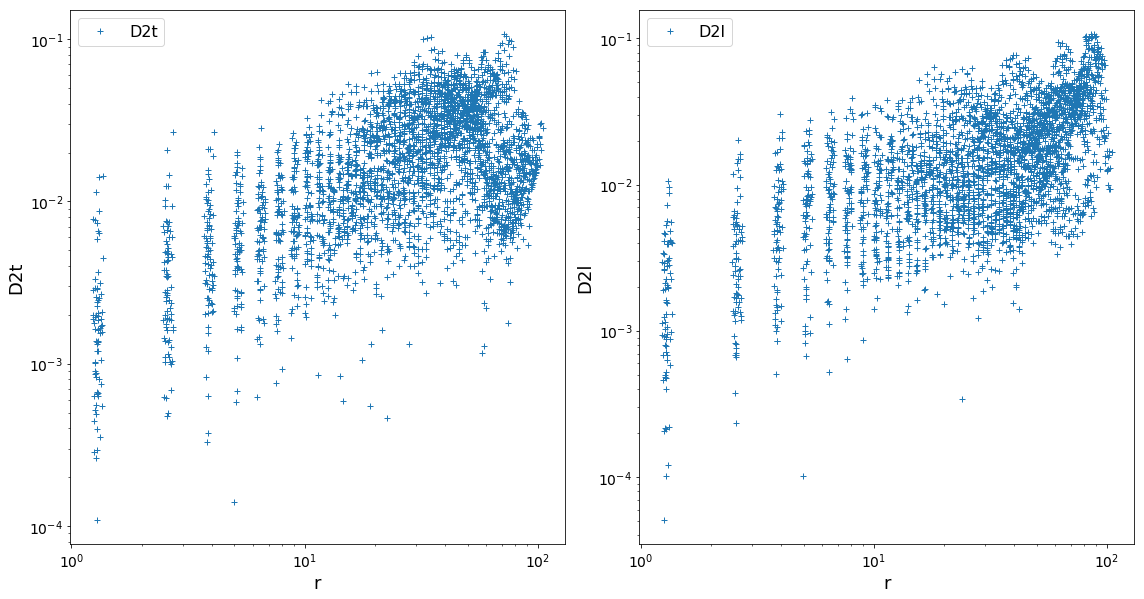

In [13]:
ax_d2u = plt.subplot(221)
D2_surface['D2t'].plot(ls='', marker='+',)
plt.xscale('log')
plt.yscale('log')
plt.legend()
ax_d2v = plt.subplot(222)
D2_surface['D2l'].plot(ls='', marker='+')
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.legend()

## 3 - Average structure functions

In [14]:
import seaobs.quality as q
r_bins = 10 ** np.arange(0.3, np.log(10), 0.1)
D2_avg = turb.average_structure_function(D2_valid, r_bins, mode='mean')
D2_avg

<xarray.Dataset>
Dimensions:      (depth: 40, r_bins: 20)
Coordinates:
  * r_bins       (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
  * depth        (depth) float64 12.0 20.0 28.0 36.0 44.0 52.0 60.0 68.0 ...
Data variables:
    D2_err       (r_bins, depth) float64 0.0004372 0.001589 0.00194 0.002919 ...
    D2l          (r_bins, depth) float64 0.005409 0.007149 0.007267 0.006416 ...
    D2t          (r_bins, depth) float64 0.001624 0.004737 0.003691 0.004687 ...
    nobs_D2_err  (r_bins, depth) float64 5.0 2.0 2.0 2.0 3.0 1.0 0.0 4.0 4.0 ...
    nobs_D2l     (r_bins, depth) float64 5.0 2.0 2.0 2.0 3.0 1.0 0.0 4.0 4.0 ...
    nobs_D2t     (r_bins, depth) float64 5.0 2.0 2.0 2.0 3.0 1.0 0.0 4.0 4.0 ...

In [48]:
def plot_D2(D2, ax=None, title=''):
    import matplotlib.colors as colors
    from matplotlib import ticker, cm
    if ax is None:
        ax = plt.gca()
    #ax.pcolormesh(Ro['r'], Ro['depth'], Ro, norm=colors.LogNorm(1e-1, 10), vmin=1e-1, vmax=10, shading='gouraud',
    #         cmap=cmclimate.cm.BlAqGrYeOrReVi200)
    D2_tot = (D2['D2l'] + D2['D2t']).sel(r_bins=slice(0, 400))
    loc = ticker.LogLocator()
    print(D2_tot)
    #cs = ax.contourf(D2_tot['r_bins'], D2_tot['depth'], D2_tot, locator=loc,
                     #cmap=cmclimate.cm.BlAqGrYeOrReVi200, levels=np.logspace(-3 , 0, 41))
    D2_tot.plot.contourf(x='r_bins', y='depth', cmap=cmclimate.cm.BlAqGrYeOrReVi200, levels=np.logspace(-2 , 0, 41))
    #cs = Ro.plot.contourf(cmap=cmclimate.cm.BlAqGrYeOrReVi200, levels=np.logspace(np.log(0.05), 1, 40))
    plt.title(title)
    ax.invert_yaxis()
    ax.set_xlim([1, 400])
    ax.set_xscale('log')
    #return cs

<xarray.DataArray (r_bins: 20, depth: 40)>
array([[ 0.007033,  0.011885,  0.010958, ...,       nan,       nan,       nan],
       [ 0.007635,  0.010142,  0.014307, ...,       nan,       nan,       nan],
       [ 0.010306,  0.014504,  0.014638, ...,       nan,       nan,       nan],
       ..., 
       [ 0.051328,  0.037909,  0.043633, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * r_bins   (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
  * depth    (depth) float64 12.0 20.0 28.0 36.0 44.0 52.0 60.0 68.0 76.0 ...


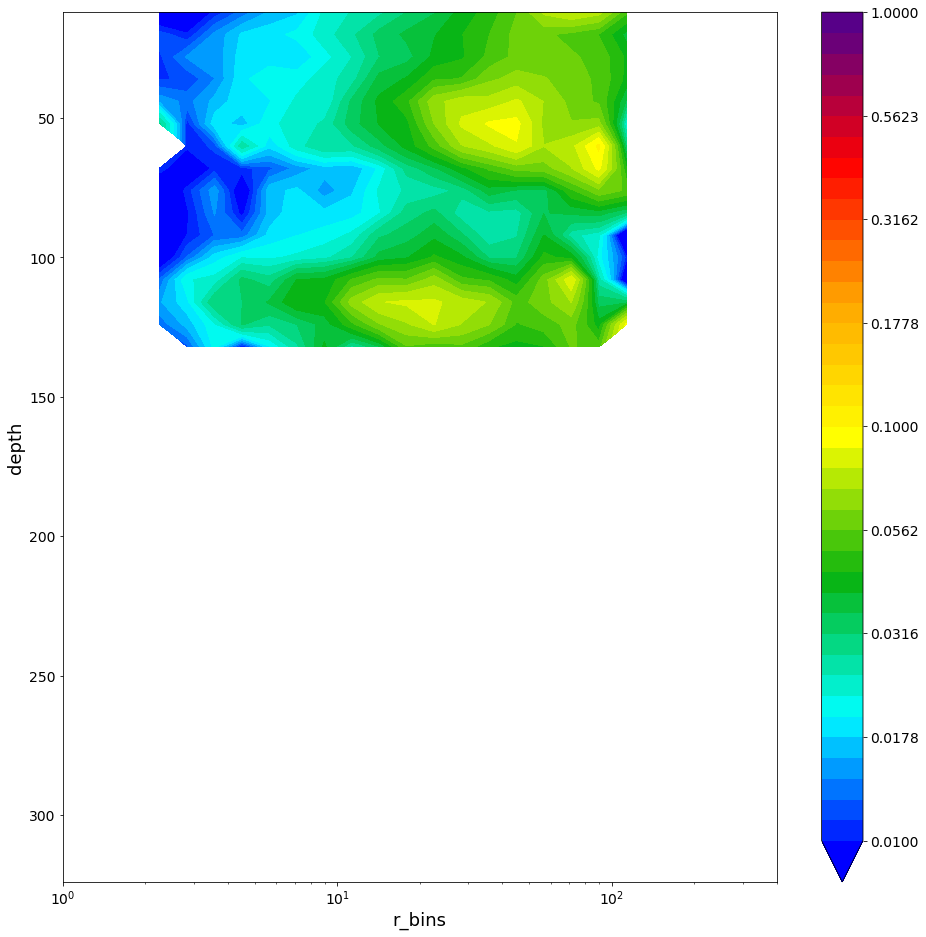

In [47]:
plot_D2(D2_avg)

In [49]:
D2_avg.isel(depth=1).dropna('r_bins')

<xarray.Dataset>
Dimensions:      (r_bins: 18)
Coordinates:
  * r_bins       (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
    depth        float64 20.0
Data variables:
    D2_err       (r_bins) float64 0.001589 0.001096 0.001654 0.001202 0.0015 ...
    D2l          (r_bins) float64 0.007149 0.005692 0.008488 0.01202 0.01238 ...
    D2t          (r_bins) float64 0.004737 0.00445 0.006016 0.006127 ...
    nobs_D2_err  (r_bins) float64 2.0 13.0 18.0 8.0 31.0 61.0 48.0 77.0 95.0 ...
    nobs_D2l     (r_bins) float64 2.0 13.0 18.0 8.0 31.0 61.0 48.0 77.0 95.0 ...
    nobs_D2t     (r_bins) float64 2.0 13.0 18.0 8.0 31.0 61.0 48.0 77.0 95.0 ...

## 5 - Helmholtz decompisition

In [8]:
D2_helm = turb.helmdec_on_strfunc(D2_avg.isel(depth=5).dropna('r_bins'), 'r_bins', ul='l', ut='t')

NameError: name 'turb' is not defined

In [17]:
D2_helm['D2l']

<xarray.DataArray 'D2l' (r_bins: 18)>
array([ 0.010147,  0.004572,  0.008672,  0.004556,  0.011967,  0.01315 ,
        0.014135,  0.014012,  0.014318,  0.014207,  0.018135,  0.020895,
        0.021443,  0.023782,  0.022157,  0.043113,  0.055264,  0.014028])
Coordinates:
  * r_bins   (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
    depth    float64 52.0

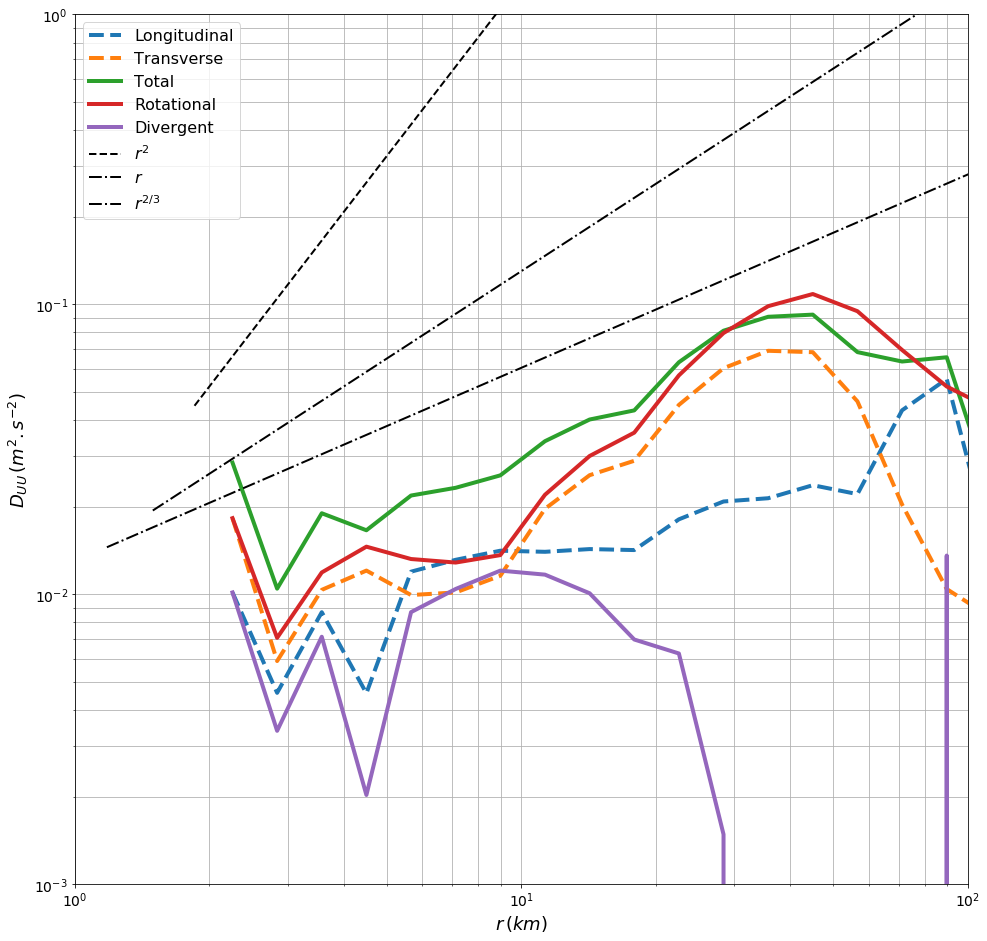

In [33]:
plot_helmholtz_decomposition(D2_helm)

# Compute on several segments

In [9]:
input_path = "/data/OBS/ADCP/SCAL/"
segments = open_ADCP_segments(input_path)

AttributeError: 'list' object has no attribute 'lon'

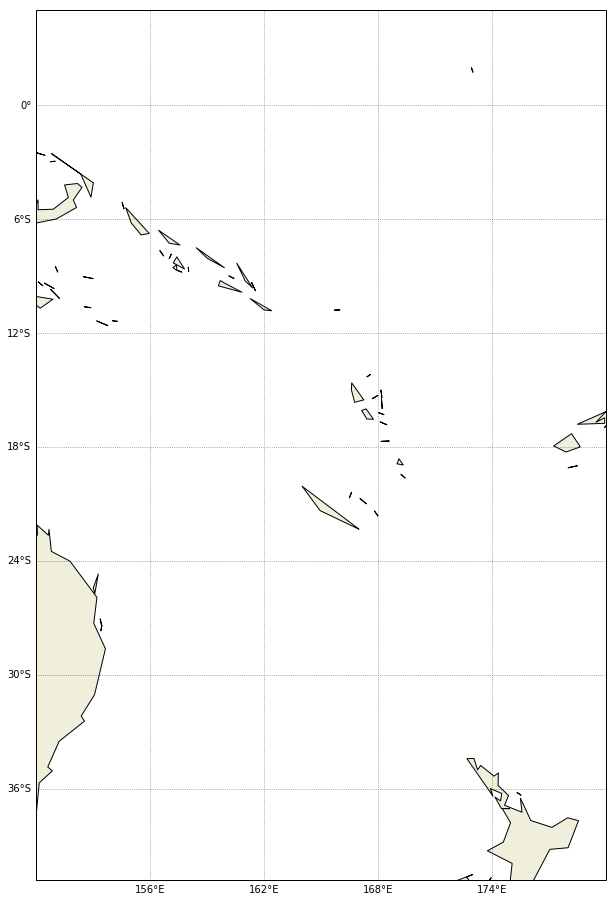

In [27]:
plot_segments(segments, lat_min=-40, lat_max=5, lon_min=150, lon_max=180)

In [32]:
import seaobs.turbulence as turb
input_path = "/data/OBS/ADCP/SCAL/"
segments = open_ADCP_segments(input_path)
D2_list = []
for seg in segments:
    seg = seg.set_coords(('lon', 'lat', 'heading', 'uship', 'vship'))
    #length = qc.get_segment_length(seg).mean()
    #maxlength = length // 2
    # Get only data with pflag equals 0
    seg = seg.where(seg['pflag'] == 0)
    # Rotate velocity vectors to get longitudinal and tranverse velocities
    nobs = seg.sizes['time']
    maxlag = nobs
    #D2 = turb.strfunc(seg, dim='time', max_lag=maxlag, vars=['u', 'v'], error_vars='e')
    D2 = velocity_structure_function(seg, dim='time', max_lag=maxlag, error='e')
    D2_valid = D2.where((D2['D2t'] > D2['D2_err']) & (D2['D2l'] > D2['D2_err']))
    r_bins = 10 ** np.arange(0.3, 3.2, 0.2)
    D2_avg = turb.average_structure_function(D2_valid, r_bins, mode='mean')
    D2_avg = D2_avg.assign_coords(lat=seg['lat'].mean(),
                                  lon=seg['lon'].mean(),
                                  time=pd.to_datetime(np.mean(pd.to_numeric(seg['time'].data))))    
    # Resample data  
    #depth_bins = range(0, 500, 25)
    #depth_labels = depth_bins[1:] - np.diff(depth_bins) / 2
    #D2_resample = D2_avg.groupby_bins('depth', depth_bins, labels=depth_labels).median('depth').rename({'depth_bins': 'depth'})
    D2_list.append(D2_avg)
D2_all = xr.concat(D2_list, dim='segment')

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountere

In [30]:
r_bins = 10 ** np.arange(0.3, 3.2, 0.2)

In [31]:
r_bins

array([    1.99526231,     3.16227766,     5.01187234,     7.94328235,
          12.58925412,    19.95262315,    31.6227766 ,    50.11872336,
          79.43282347,   125.89254118,   199.5262315 ,   316.22776602,
         501.18723363,   794.32823472,  1258.92541179])

In [8]:
def get_D2_over_depth_range(D2, depth_range=slice(0, 100), min_obs=50):
    D2_depth = (D2.sel(depth=depth_range).mean('depth')
                  .drop(['nobs_D2_err', 'nobs_D2l', 'nobs_D2t'])
                )
    nobs = D2['nobs_D2l'].sel(depth=slice(0, 100)).sum('depth')
    D2_depth_valid = D2_depth.where(nobs > min_obs)
    return D2_depth_valid

In [9]:
def get_D2_by_season(D2, season='DJF'):
    D2_by_season = dict(D2.groupby('time.season'))
    return D2_by_season[season]

In [10]:
def get_D2_by_month(D2, month=0):
    D2_by_month = dict(D2.groupby('time.month'))
    return D2_by_month[month]

In [11]:
D2_0_100 = get_D2_over_depth_range(D2_all, depth_range=slice(0, 100), min_obs=100)
D2_100_200 = get_D2_over_depth_range(D2_all, depth_range=slice(100, 200), min_obs=100)
D2_200_500 = get_D2_over_depth_range(D2_all, depth_range=slice(200, 500), min_obs=100)

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.001595 0.002086 0.002662 0.003187 0.003668 ...
    D2l      (r_bins) float64 0.007192 0.009993 0.0136 0.01965 0.02844 ...
    D2t      (r_bins) float64 0.007313 0.009851 0.01541 0.02427 0.03676 ...
    D2d      (r_bins) float64 0.007192 0.009984 0.0133 0.01797 0.02388 ...
    D2r      (r_bins) float64 0.007313 0.00986 0.01571 0.02595 0.04133 ...


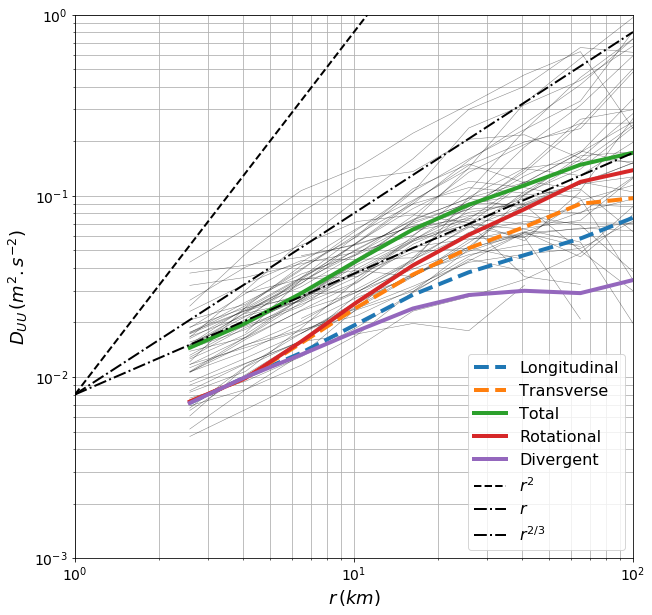

In [12]:
plot_helmholtz_decomposition(D2_0_100)

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.001176 0.001545 0.001921 0.002401 0.002804 ...
    D2l      (r_bins) float64 0.00488 0.006435 0.009002 0.01247 0.01745 ...
    D2t      (r_bins) float64 0.004694 0.007408 0.01082 0.01573 0.02309 ...
    D2d      (r_bins) float64 0.00488 0.00631 0.008256 0.01059 0.01357 ...
    D2r      (r_bins) float64 0.004694 0.007533 0.01157 0.01761 0.02696 ...


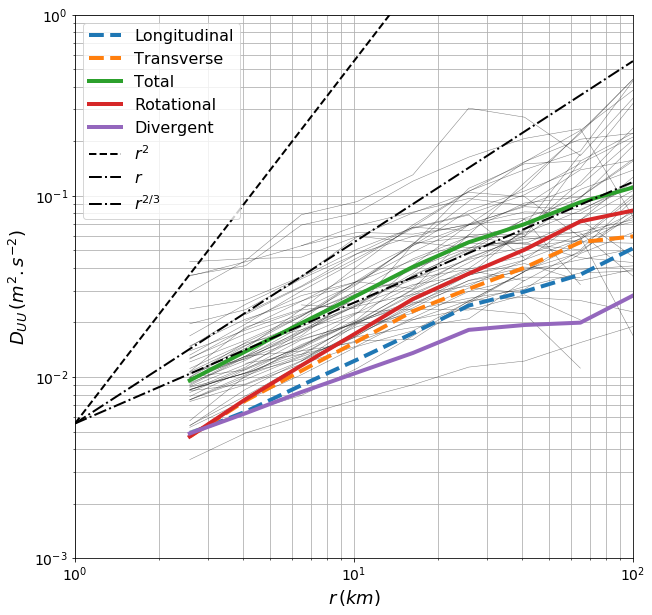

In [13]:
plot_helmholtz_decomposition(D2_100_200)

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.00123 0.001577 0.001956 0.002347 0.002683 ...
    D2l      (r_bins) float64 0.005118 0.007507 0.01028 0.01367 0.01679 ...
    D2t      (r_bins) float64 0.00499 0.006889 0.009269 0.01284 0.01717 ...
    D2d      (r_bins) float64 0.005118 0.007658 0.0108 0.01464 0.01792 ...
    D2r      (r_bins) float64 0.00499 0.006738 0.00875 0.01187 0.01603 ...


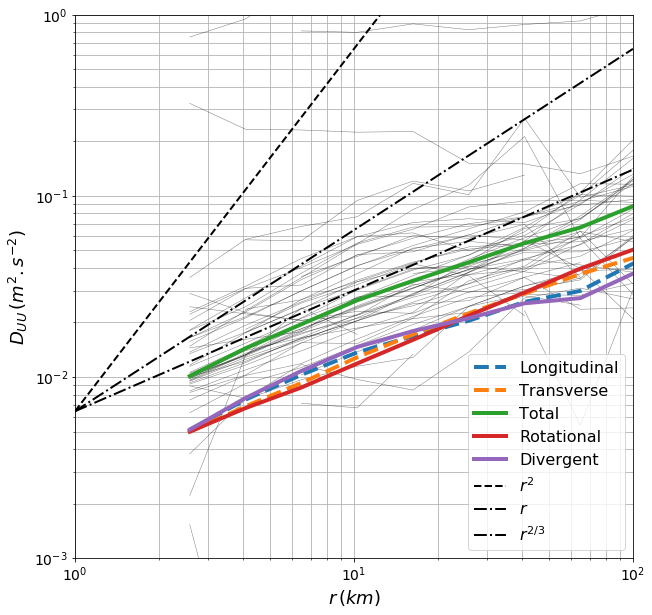

In [14]:
plot_helmholtz_decomposition(D2_200_500)

In [15]:
D2_0_100_DJF = get_D2_by_season(D2_0_100, season='DJF')
D2_0_100_SON = get_D2_by_season(D2_0_100, season='SON')
D2_0_100_JJA = get_D2_by_season(D2_0_100, season='JJA')
D2_0_100_MAM = get_D2_by_season(D2_0_100, season='MAM')
D2_0_100_summer = xr.concat((D2_0_100_SON, D2_0_100_DJF), dim='segment')
D2_0_100_winter = xr.concat((D2_0_100_MAM, D2_0_100_JJA), dim='segment')

In [16]:
D2_100_200_DJF = get_D2_by_season(D2_100_200, season='DJF')
D2_100_200_SON = get_D2_by_season(D2_100_200, season='SON')
D2_100_200_JJA = get_D2_by_season(D2_100_200, season='JJA')
D2_100_200_MAM = get_D2_by_season(D2_100_200, season='MAM')
D2_100_200_summer = xr.concat((D2_100_200_SON, D2_100_200_DJF), dim='segment')
D2_100_200_winter = xr.concat((D2_100_200_MAM, D2_100_200_JJA), dim='segment')

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.0008467 0.0009386 0.001088 0.001145 0.001203 ...
    D2l      (r_bins) float64 0.004694 0.006352 0.009023 0.01506 0.02428 ...
    D2t      (r_bins) float64 0.005647 0.008531 0.01185 0.02326 0.04001 ...
    D2d      (r_bins) float64 0.004694 0.005672 0.007184 0.01089 0.0148 ...
    D2r      (r_bins) float64 0.005647 0.009212 0.01369 0.02744 0.04949 ...


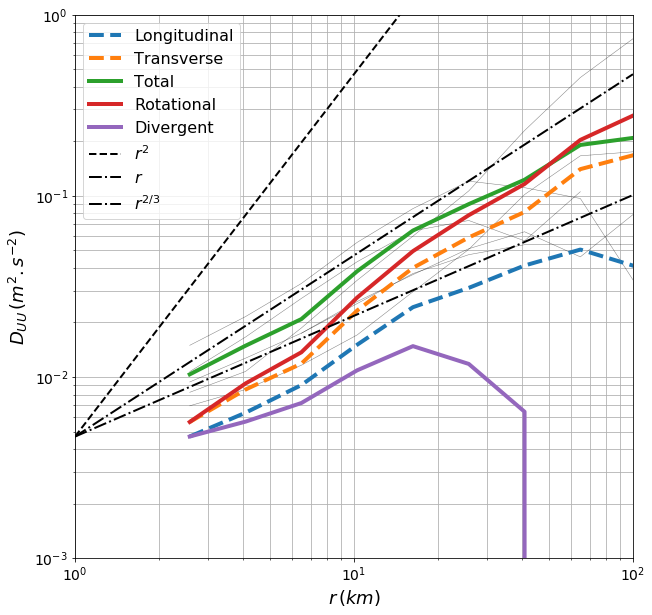

In [17]:
D2_0_100_November = get_D2_by_month(D2_0_100, month=11)
D2_0_100_December = get_D2_by_month(D2_0_100, month=12)
D2_0_100_ND = xr.concat((D2_0_100_November, D2_0_100_December), dim='segment')
plot_helmholtz_decomposition( get_D2_by_month(D2_0_100, month=10))

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.0007474 0.0008856 0.001088 0.001145 0.001207 ...
    D2l      (r_bins) float64 0.004448 0.006137 0.009023 0.01565 0.02525 ...
    D2t      (r_bins) float64 0.004832 0.007657 0.01185 0.01797 0.03093 ...
    D2d      (r_bins) float64 0.004448 0.005744 0.007664 0.01304 0.02091 ...
    D2r      (r_bins) float64 0.004832 0.00805 0.01321 0.02058 0.03526 ...


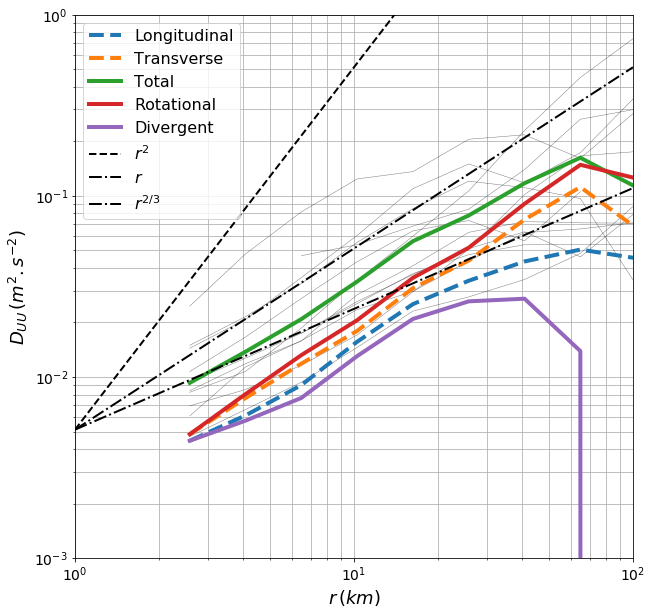

In [18]:
plot_helmholtz_decomposition(D2_0_100_summer)

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.001749 0.002223 0.002761 0.003382 0.003921 ...
    D2l      (r_bins) float64 0.007503 0.01121 0.01386 0.02036 0.02844 ...
    D2t      (r_bins) float64 0.008309 0.0118 0.01616 0.02573 0.03899 ...
    D2d      (r_bins) float64 0.007503 0.01086 0.01292 0.01775 0.02232 ...
    D2r      (r_bins) float64 0.008309 0.01214 0.0171 0.02834 0.04511 ...


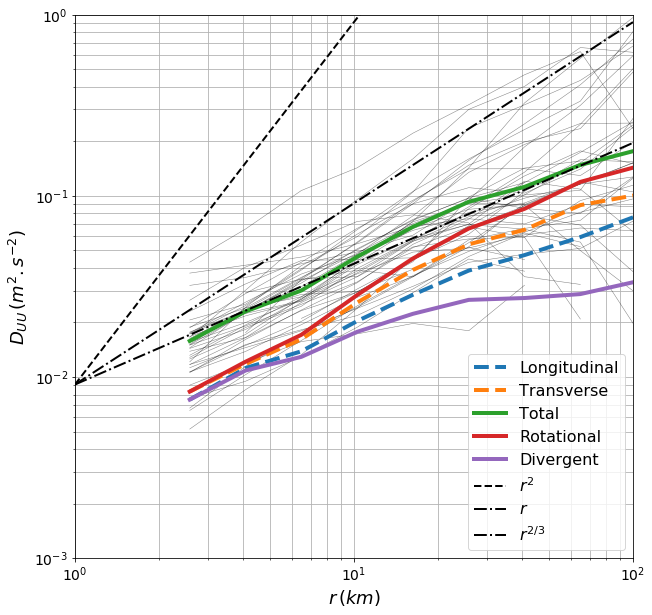

In [19]:
plot_helmholtz_decomposition(D2_0_100_winter)

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.001199 0.001603 0.002035 0.002538 0.002952 ...
    D2l      (r_bins) float64 0.00488 0.006509 0.009105 0.01258 0.01745 ...
    D2t      (r_bins) float64 0.004793 0.007449 0.01122 0.01592 0.02378 ...
    D2d      (r_bins) float64 0.00488 0.006361 0.008291 0.01053 0.01326 ...
    D2r      (r_bins) float64 0.004793 0.007597 0.01203 0.01797 0.02797 ...


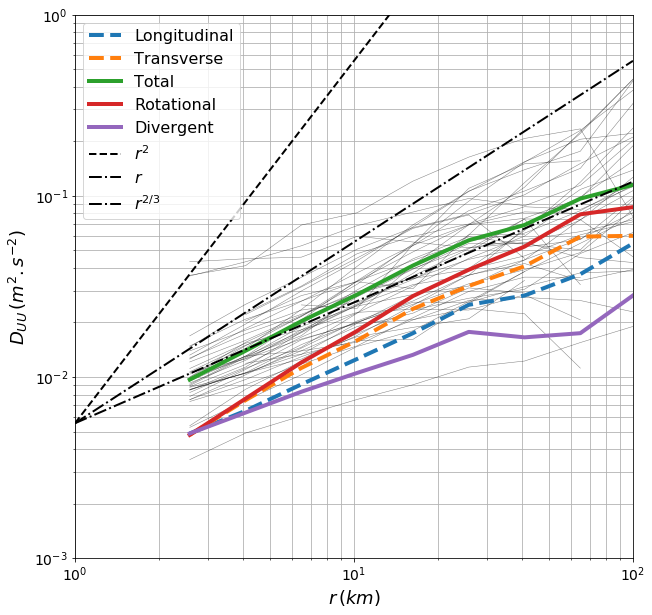

In [20]:
plot_helmholtz_decomposition(D2_100_200_winter)

In [140]:
D2_0_100_winter

<xarray.Dataset>
Dimensions:  (r_bins: 17, segment: 22)
Coordinates:
  * r_bins   (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
    nprofs   float64 1.0
    lat      (segment) float64 -21.18 -21.44 -22.49 -21.15 -21.73 -22.43 ...
    lon      (segment) float64 171.0 173.6 170.5 174.1 173.2 171.5 171.8 ...
    time     (segment) datetime64[ns] 2007-05-04T13:16:42.354929664 ...
Dimensions without coordinates: segment
Data variables:
    D2_err   (segment, r_bins) float64 0.0005563 0.0006435 0.0006641 ...
    D2l      (segment, r_bins) float64 0.003083 0.00356 0.004695 0.005739 ...
    D2t      (segment, r_bins) float64 0.003723 0.003286 0.005156 0.007988 ...

<xarray.Dataset>
Dimensions:  (r_bins: 9)
Coordinates:
  * r_bins   (r_bins) float64 2.579 4.087 6.478 10.27 16.27 25.79 40.87 ...
Data variables:
    D2_err   (r_bins) float64 0.001749 0.002223 0.002761 0.003382 0.003921 ...
    D2l      (r_bins) float64 0.007503 0.01121 0.01386 0.02036 0.02844 ...
    D2t      (r_bins) float64 0.008309 0.0118 0.01616 0.02573 0.03899 ...
    D2d      (r_bins) float64 0.007503 0.01086 0.01292 0.01775 0.02232 ...
    D2r      (r_bins) float64 0.008309 0.01214 0.0171 0.02834 0.04511 ...


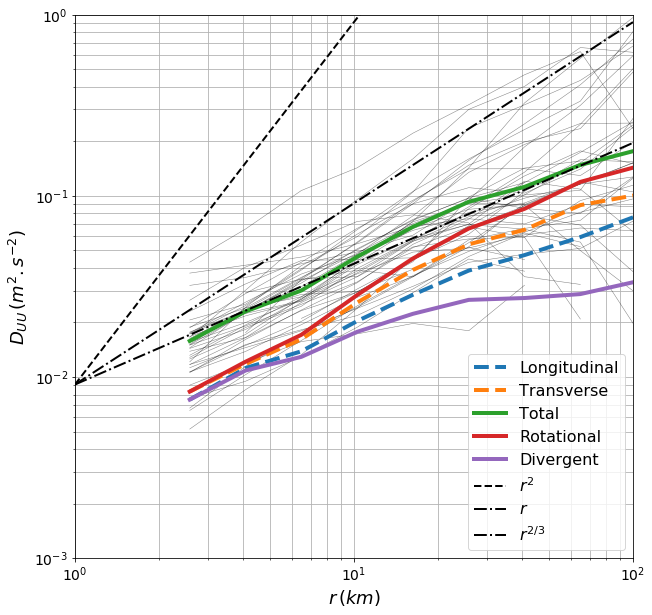

In [21]:
plot_helmholtz_decomposition(D2_0_100_winter)

<xarray.Dataset>
Dimensions:  (r_bins: 17)
Coordinates:
  * r_bins   (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
Data variables:
    D2_err   (r_bins) float64 0.0005563 0.0007358 0.0006641 0.000774 ...
    D2l      (r_bins) float64 0.003083 0.003611 0.004695 0.0057 0.00664 ...
    D2t      (r_bins) float64 0.003723 0.003287 0.005156 0.005313 0.006968 ...
    D2d      (r_bins) float64 0.003083 0.003561 0.00464 0.005625 0.006582 ...
    D2r      (r_bins) float64 0.003723 0.003336 0.005211 0.005388 0.007026 ...


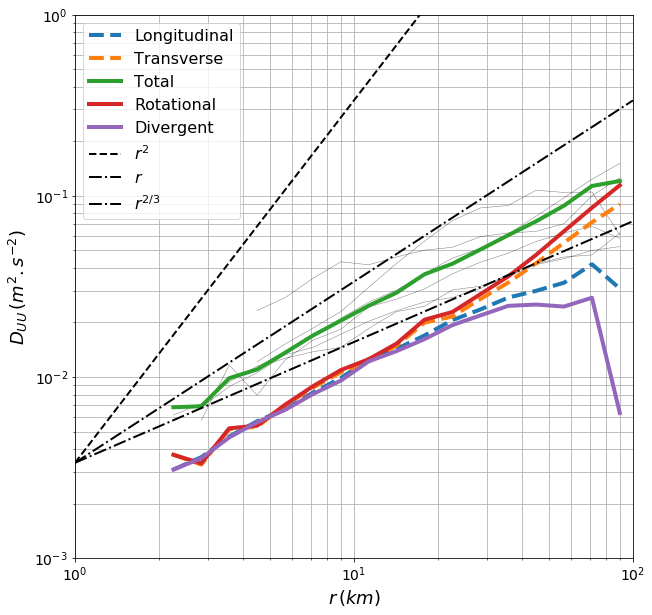

In [149]:
plot_helmholtz_decomposition(D2_0_100_MAM)

<xarray.Dataset>
Dimensions:  (r_bins: 17)
Coordinates:
  * r_bins   (r_bins) float64 2.254 2.837 3.572 4.496 5.661 7.126 8.972 ...
Data variables:
    D2_err   (r_bins) float64 0.0006662 0.0009011 0.0008272 0.001118 ...
    D2l      (r_bins) float64 0.004465 0.004141 0.00533 0.00613 0.006642 ...
    D2t      (r_bins) float64 0.004211 0.003978 0.005269 0.006048 0.006904 ...
    D2d      (r_bins) float64 0.004465 0.004191 0.005407 0.006223 0.006719 ...
    D2r      (r_bins) float64 0.004211 0.003928 0.005192 0.005954 0.006827 ...


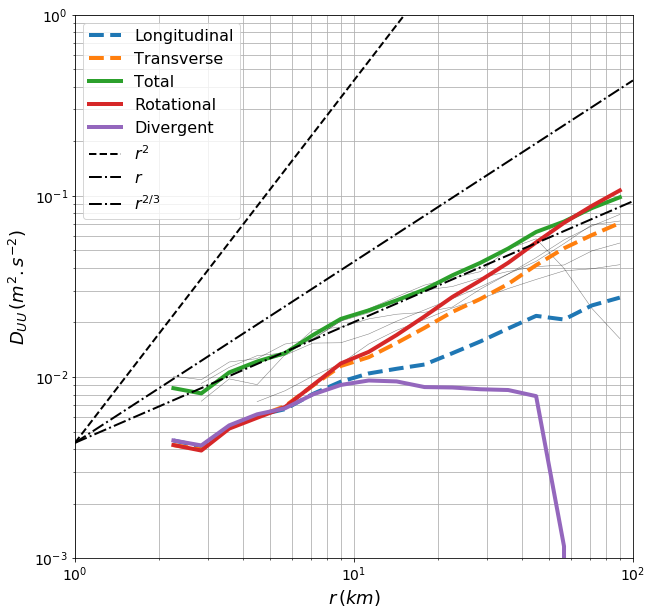

In [148]:
plot_helmholtz_decomposition(D2_0_100_DJF)

In [22]:
depth_bins = range(0, 500, 50)
depth_labels = depth_bins[1:] - np.diff(depth_bins) / 2
D2_resample = D2_mean.groupby_bins('depth', depth_bins, labels=depth_labels).mean('depth').rename({'depth_bins': 'depth'})

NameError: name 'D2_mean' is not defined

In [23]:
plot_D2(D2_resample)

NameError: name 'plot_D2' is not defined

In [ ]:
slopes = compute_slope(D2_resample)

# Structure function of the first 50 meters

In [ ]:
plot_D2_total(D2_0_100.mean('depth'), xlim=[1, 100],  ylim=[1e-3, 1], title=r'Surface layer $(0-100\,m)$')

In [ ]:
plot_D2_by_season(D2_0_100.mean('depth'), xlim=[1, 100], ylim=[1e-3, 1])

# Structure function 100-200 meters

In [ ]:
plot_D2_total(D2_100_200.mean('depth'), xlim=[1, 100], ylim=[1e-3, 1])

In [ ]:
plot_D2_by_season(D2_100_200.mean('depth'), xlim=[1, 100], ylim=[1e-3, 1])

# Structure function 200-500 meters

In [ ]:
plot_D2_total(D2_200_500.mean('depth'), xlim=[1, 100], ylim=[1e-3, 1])

In [ ]:
plot_D2_by_season(D2_seg.sel(depth=slice(300, 500)).mean('depth'), xlim=[1, 100], ylim=[1e-3, 1])

# Compute slopes

In [ ]:
print(slopes)

In [ ]:
valid_slopes = slopes.where(slopes > 0.3)

In [ ]:
valid_slopes.dropna('segment')['segment']

In [ ]:
slopes_by_season = valid_slopes.groupby('time.season').median('segment')

In [ ]:
plt.figure(figsize=(5,8))
ax = plt.gca()
def plot_slopes(data, label):
    plt.plot(data, data['depth'], lw=4, label=label)
for seas in slopes_by_season['season']:
    plot_slopes(slopes_by_season.sel(season=seas), label=seas.data)
plot_slopes(valid_slopes.median('segment'), label='Annual')
ylim = ax.get_ylim()
plt.plot([2./3, 2./3], ylim, lw=2, ls='--', color='black')
plt.plot([1., 1.], ylim, lw=2, ls='--', color='black')
plt.gca().invert_yaxis()
plt.grid()
ax = plt.gca()
ax.set_xlim([0, 2])
ax.set_ylim([500, 0])
ax.set_xlabel('D2 slope (3-100 km)')
ax.set_ylabel('Depth (m)')
plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5,8))
ax = plt.gca()
def plot_slopes(data, label):
    plt.plot(data, data['depth'], lw=4, label=label)
plot_slopes(valid_slopes.median('segment'), label='Annual')
ylim = ax.get_ylim()
plt.plot([2./3, 2./3], ylim, lw=2, ls='--', color='black')
plt.plot([1., 1.], ylim, lw=2, ls='--', color='black')
plt.gca().invert_yaxis()
plt.grid()
ax = plt.gca()
ax.set_xlim([0, 2])
ax.set_ylim([500, 0])
ax.set_xlabel('D2 slope (3-100 km)')
ax.set_ylabel('Depth (m)')
plt.legend()
plt.tight_layout()